<div class="alert alert-block alert-info">
<center> <h1> Master in Data Science and Advanced Analytics </h1> </center> <br>
<center> PROJECT 2022/2023 </center>

# Deep Learning - Brain Tumor
*Group Members*:

|      | Student Name                  | Student ID |
|---   |-------------------------------|------------|
| 1    | Mahmoud Ahmed                 | 20221397   |
| 2    | Alex Adrián Santander Morales | 20220658   |
| 3    | Skander Chaabini              | 20221041   |
| 4    | Karim Miladi                  | 20220720   |
| 5    | Mohamed Ettaher Ben Slama     | 20221039   |

# Data Preprocessing

In order to load our dataset and labeling each element :

- Read the images in gray.
- Preprocess the image
    - Resize the image to (256, 256) to feed it as an input to the neural network.
    - Convert the image to grayscale as contrast and texture info is most important in grayscale rather than RGB channels.
    - Apply normalization because we want pixel values to be scaled to the range 0-1.
    - Save processed images into new directory.

### Preprocess Data

In [12]:
preprocess_data(dataset_path, processed_dataset)

Processing Testing/meningioma images: 100%|██████████| 306/306 [00:00<00:00, 503.09it/s]


### Plot sample

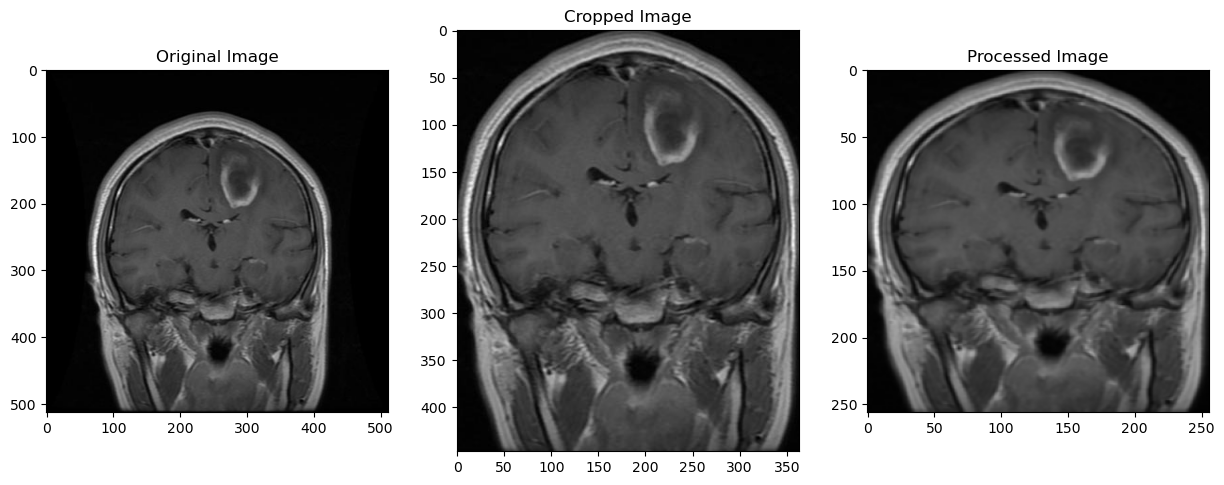

In [13]:
processed_sample = preprocess_image(cropped_sample)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cropped_sample)
plt.title('Cropped Image')

plt.subplot(1, 3, 3)
plt.imshow(processed_sample)
plt.title('Processed Image')

plt.show()

### Load datasets

Load preprocessed images into train & test sets,

In [6]:
train_path = os.path.join(processed_dataset, train_dataset)
test_path = os.path.join(processed_dataset, test_dataset)
labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

X, y = load_data(train_path, labels)
X_test, y_test = load_data(test_path, labels)

In [7]:
print(f'Number of samples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')
print(f'Number of classes: {len(np.unique(y))}')

Number of samples is: 5712
X shape is: (5712, 256, 256, 3)
y shape is: (5712,)
Number of classes: 4


### Split training dataset

Split X and y into training, validation sets.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [9]:
print ("number of training samples = " + str(X_train.shape[0]))
print ("number of validation samples = " + str(X_val.shape[0]))
print ("number of test samples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training samples = 3998
number of validation samples = 1714
number of test samples = 1311
X_train shape: (3998, 256, 256, 3)
Y_train shape: (3998,)
X_val shape: (1714, 256, 256, 3)
Y_val shape: (1714,)
X_test shape: (1311, 256, 256, 3)
Y_test shape: (1311,)


# Data Augmentation
Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc of each training instances.

In order to make the most of our few training samples here, we augment them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

### Build data generator

Define an image data generator to apply random transformations to the training data.

In [4]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

### Plot sample

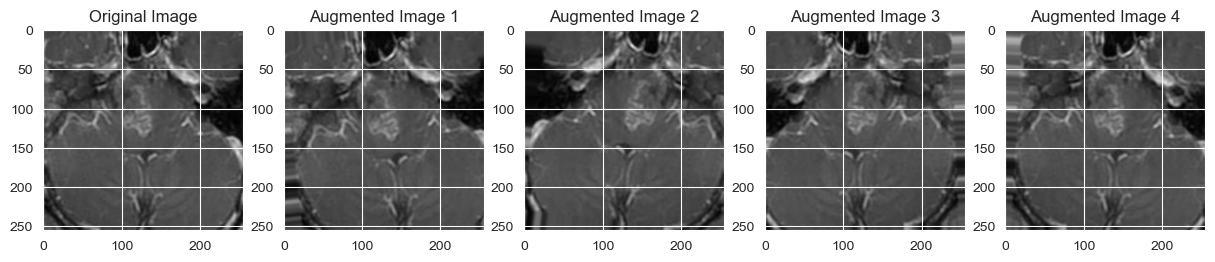

In [53]:
# Reshape image to (1, height, width, channel)
img = np.reshape(X_train[0], (1,) + X_train[0].shape)


# Generate augmented images
augmented_image = data_generator.flow(img)

# Plot original and augmented images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(X_train[0])
axs[0].set_title("Original Image")
for i in range(1, 5):
    axs[i].imshow(augmented_image.next()[0].astype('int'))
    axs[i].set_title("Augmented Image {}".format(i))
plt.show()

### Generate augmented data

Generate augmented images data and save it to new location.

In [11]:
# Add dimension (channel) grayscale to X_train to make it compatible with Keras' input format for 2D grayscale images
#X_train_expanded = np.expand_dims(X_train, axis=-1)
#X_test_expanded = np.expand_dims(X_test, axis=-1)

# Compute the number of batches based on the total number of training samples
total_samples = len(X_train)
#num_batches = ceil(total_samples / batch_size)
num_batches = 10

# Initialize empty lists for X and y
X_train_augmented = []
y_train_augmented = []

X_train_augmented_batches = []
y_train_augmented_batches = []

progress_bar = tqdm(total=num_batches, desc=f'Augmenting images', dynamic_ncols=True)
for i in range(num_batches): # generating all batches may take forever
    # Generate augmented data on-the-fly in batches.
    batch = data_generator.flow(X_train, y_train, batch_size=32, shuffle=True)
    X_batch, y_batch = batch.next()

    X_train_augmented.append(X_batch)
    y_train_augmented.append(y_batch)

    progress_bar.update(1)

# Concatenate the augmented images and labels
X_train_augmented_batches = np.concatenate(X_train_augmented, axis=0)
y_train_augmented_batches = np.concatenate(y_train_augmented, axis=0)


# Reshape the augmented data to (num_of_sample, number_patches, 256, 256, 1)
#X_train_augmented_batches = np.expand_dims(X_train_augmented_batches, axis=-1)
X_train_augmented_batches = np.reshape(X_train_augmented_batches, (-1, num_batches, 256, 256, 3))

progress_bar.close()

Augmenting images: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [12]:
print(len(X_train_augmented_batches))
print(X_train_augmented_batches.shape)

32
(32, 10, 256, 256, 3)


### Save the augmented data

In [13]:
# Save the original data and generate augmented images
save_augmented_images(data=[X_train_augmented_batches, y_train_augmented_batches], destination_path=augmented_dataset, labels=labels)

print('{} batch with total {} augmented image generated successfully!'.format(num_batches, total_samples * num_batches))

Saving augmented images: 100%|██████████| 32/32 [00:00<00:00, 166.36it/s]

10 batch with total 39980 augmented image generated successfully!
